In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
import shap
shap.initjs()

import graphviz
from sklearn.tree import export_graphviz
import pydot

In [2]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.cluster import FeatureAgglomeration

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from scipy.stats import rankdata

In [3]:
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils import np_utils

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


this function is used to get the precision of the model @ top K

In [4]:
def score_topK(yv, ypred):
    print('Precision @')
    ttest = pd.DataFrame({'true':yv,'pred1':ypred})
    ttest['ranking'] = rankdata(ttest.pred1, 'min')
    ttest['ranking'] = ttest.ranking.max()-ttest.ranking+1
    for topK in [50,100,150,175]:
        ttest['pred'+str(topK)] = ttest.ranking <= topK
        print('TOP K %d ' % (topK))
        if ttest.shape[0]:
            cm = confusion_matrix(ttest.true, ttest['pred'+str(topK)])
            print('-- %.2f #Churners: %d #TT: %d #FT: %d' %
                   (precision_score(ttest.true, ttest['pred'+str(topK)]).round(2),
                    cm[1][1]+cm[0][1], cm[1][1], cm[0][1]))
            
    return ttest.loc[ttest.ranking<=175, 'pred1'].min()

data is loaded, forecast features are discarded as well as empty columns - all tables are joined into a wide matrix indexed by client id

In [5]:
path = 'files/'
dates_cols = ['date_activ','date_end','date_first_activ','date_modif_prod','date_renewal']
cat_cols = ['activity_new', 'channel_sales', 'has_gas', 'origin_up']
target_cols = ['churn']

training_data = pd.read_csv(path+'ml_case_training_data.csv', parse_dates=dates_cols).dropna(axis=1, how='all')
training_hist_data = pd.read_csv(path+'ml_case_training_hist_data.csv')
training_output = pd.read_csv(path+'ml_case_training_output.csv')
test_data = pd.read_csv(path+'ml_case_test_data.csv', parse_dates=dates_cols, usecols=training_data.columns)
test_hist_data = pd.read_csv(path+'ml_case_test_hist_data.csv')

In [6]:
prices = ['price_p1_fix','price_p1_var','price_p2_fix','price_p2_var','price_p3_fix','price_p3_var']
df_hist_data = training_hist_data.append(test_hist_data).pivot_table(index='id', columns='price_date', values=prices)
df_hist_data.columns = ['_'.join(col).strip().replace('-','') for col in df_hist_data.columns.values]
ts_cols = df_hist_data.columns.tolist()

In [7]:
#ts_cols

In [8]:
all_cols = training_data.columns.tolist()
num_cols = list(set(all_cols)-set(dates_cols)-set(ts_cols)-set(target_cols)-set(cat_cols)-set(['id']))
num_cols = [c for c in num_cols if 'forecast' not in c]
features = num_cols + cat_cols + dates_cols + ts_cols
len(features)

91

# monthly prices evolution

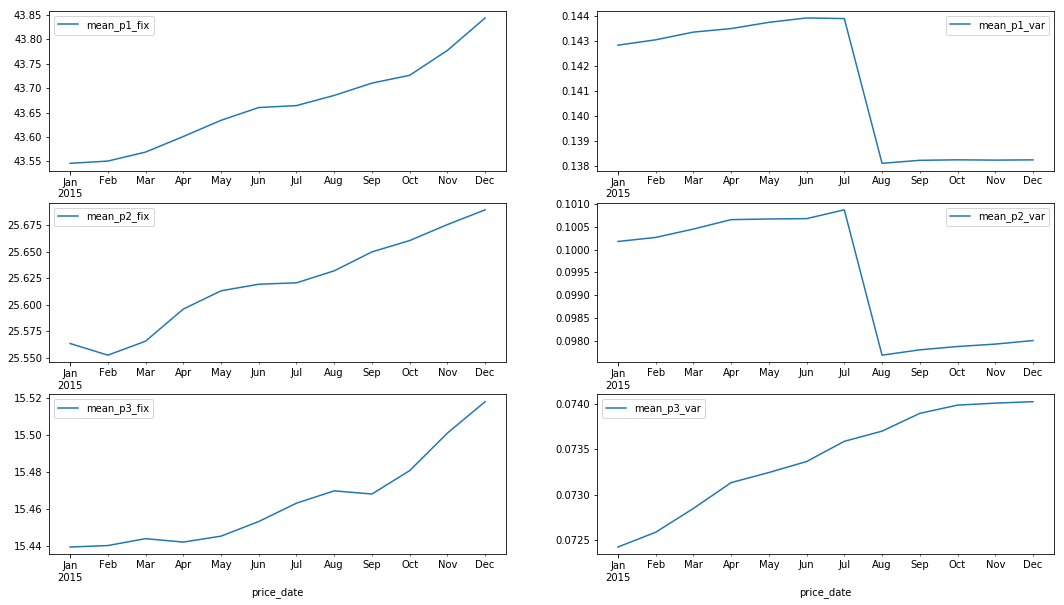

In [9]:
df = training_hist_data.append(test_hist_data).replace(0, np.nan)
df.price_date = pd.to_datetime(df.price_date)

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10);fig.set_figwidth(18)

for i,c in enumerate(prices):
    df.groupby('price_date')[c].mean().plot(ax=axes[i//2,i%2])
    axes[i//2,i%2].legend(['mean_'+c[6:]])

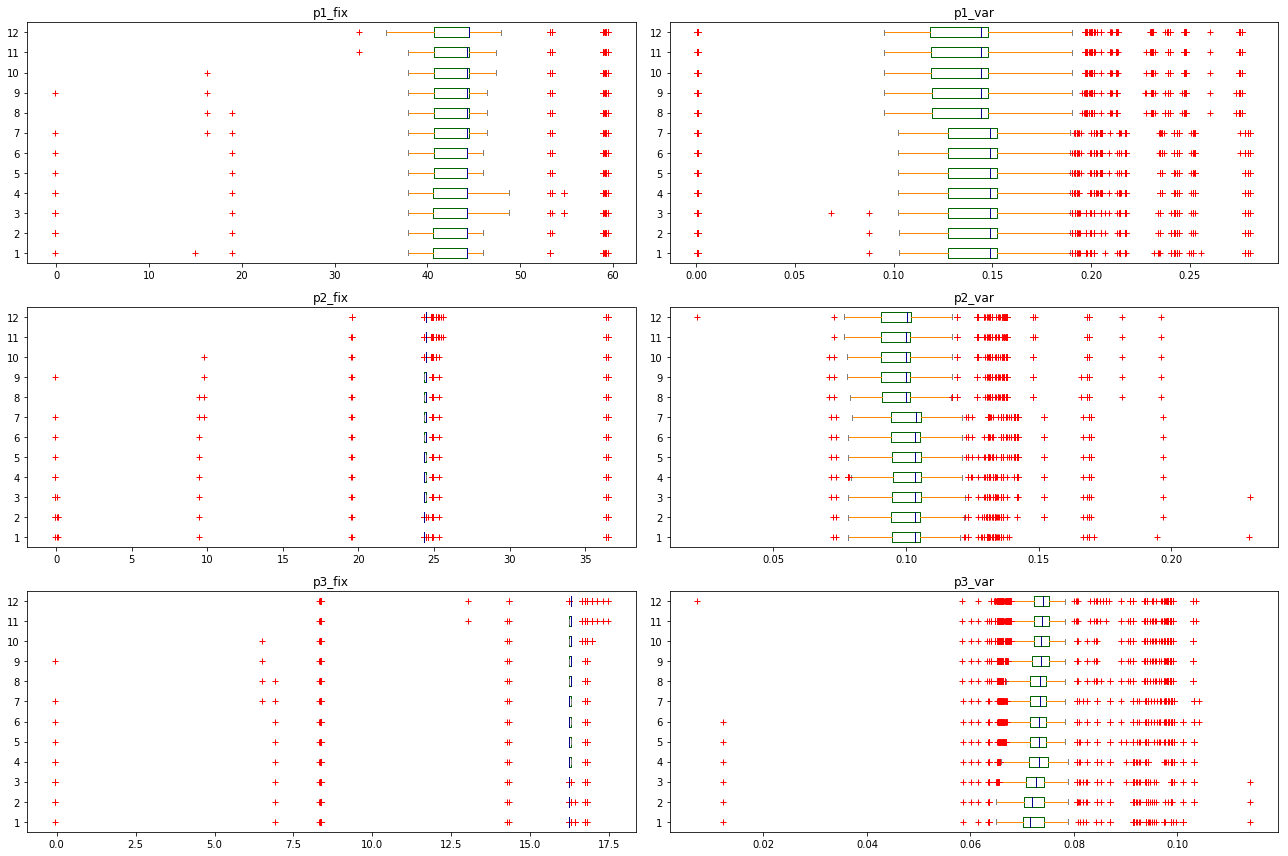

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(12);fig.set_figwidth(18)

for i,c in enumerate(prices):
    tmp = df[['id','price_date',c]]
    df.pivot(index='id', columns='price_date', 
             values=c).rename(lambda x: x.month, axis='columns').plot.box(ax=axes[i//2,i%2],
             color=dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray'), sym='r+',
             vert=False)
    axes[i//2,i%2].set_title(c[6:])
plt.tight_layout()

# cleaning and basic feature engineering

In [11]:
def get_df(scale=False, fillna=False):
    
    global training_data, training_output, test_data, df_hist_data, cat_cols, dates_cols, ts_cols, num_cols
    df = training_data.merge(training_output).append(test_data).set_index('id').join(df_hist_data)
    means = {}
    stds = {}
    
    for c in df.columns:
        if c in cat_cols:
            print('cat %s' % c)
            df[c] = df[c].astype('category').cat.codes
        elif c in dates_cols:
            print('date % s' % c)
            df[c] = pd.datetime(2016,1,1)-df[c]
            df.loc[df[c].notnull(), c] = df.loc[df[c].notnull(), c].dt.days.astype(int)
        if scale and c in dates_cols+ts_cols+num_cols:
            means[c]=df.loc[df.churn.notnull(), c].mean()
            stds[c]=df.loc[df.churn.notnull(), c].std()
            df[c]=((df[c]-means[c])/stds[c])
        if fillna and c in dates_cols+ts_cols+num_cols:
            df[c].fillna(df.loc[df.churn.notnull(), c].mean(), inplace=True)
            
    return df

df=get_df()

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


Viewing churning clients relative to some features

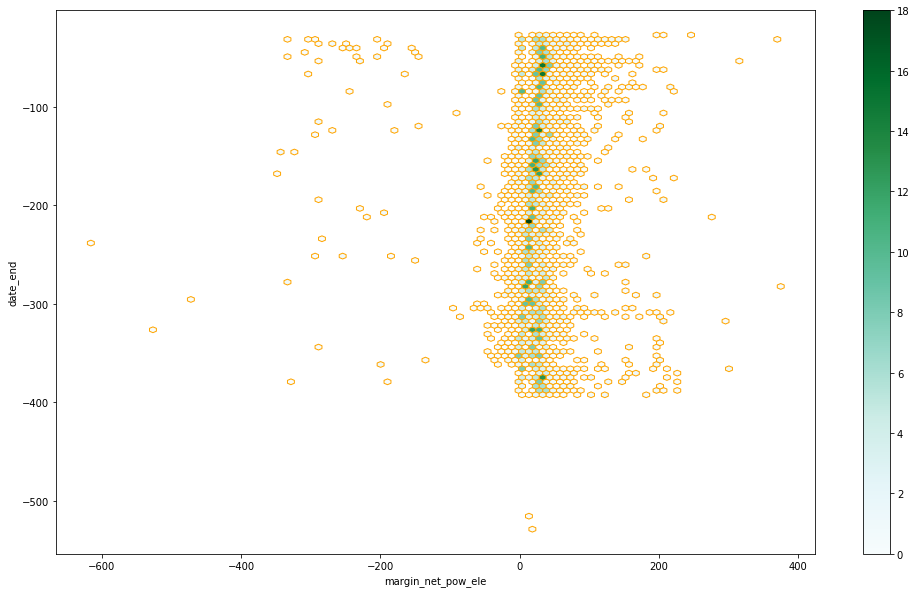

In [12]:
df.loc[(df.date_end<365)&(df.date_end>-365*2),
       ['margin_net_pow_ele','date_end','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_end', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

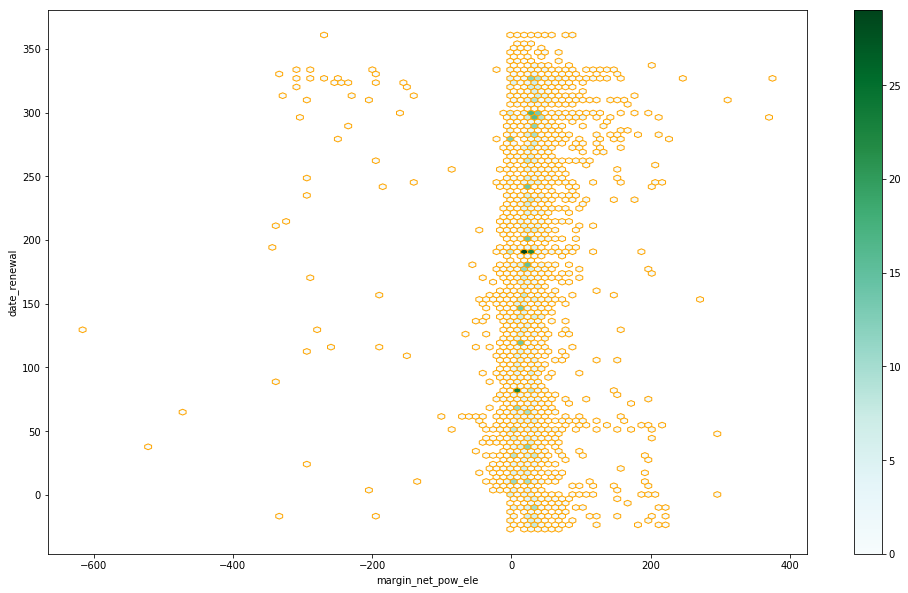

In [13]:
df.loc[(df.date_renewal<365)&(df.date_renewal>-365*2),
       ['margin_net_pow_ele','date_renewal','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_renewal', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

# decision Tree

In [14]:
df=get_df(scale=False, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


In [15]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xt, yt)
y_pred = dt.predict_proba(Xv)
score_topK(yv, y_pred[:,1])

Precision @
TOP K 50 
-- 0.29 #Churners: 31 #TT: 9 #FT: 22
TOP K 100 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63
TOP K 150 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63
TOP K 175 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63


0.2315270935960591

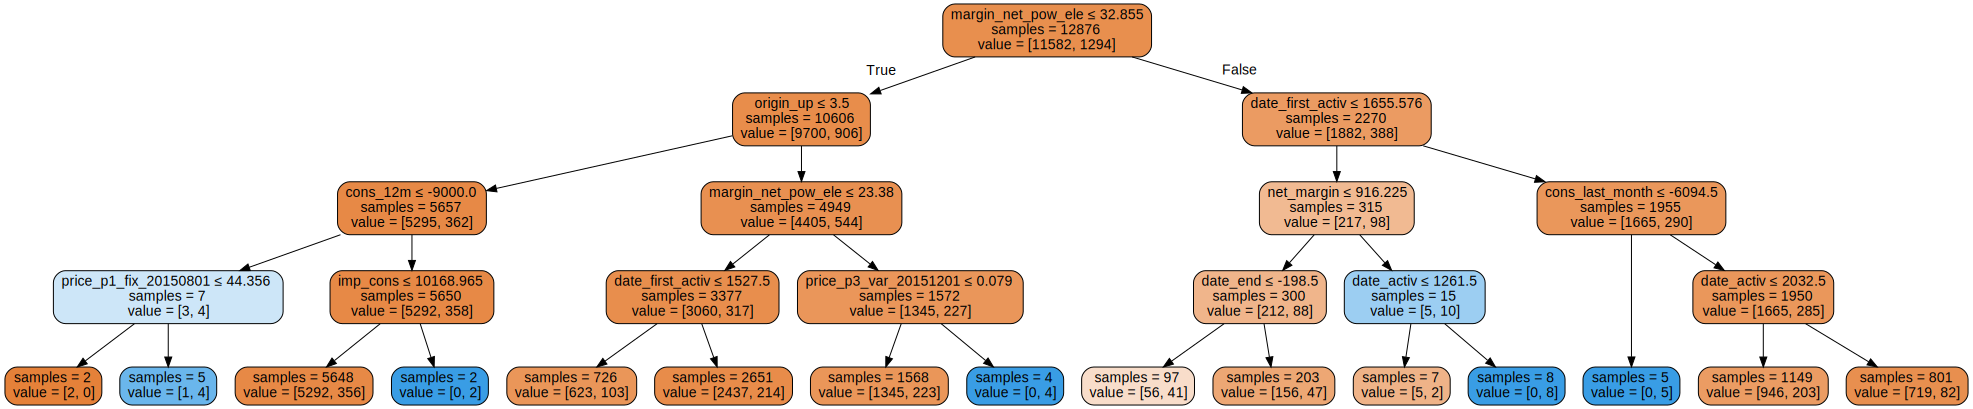

In [16]:
dot_data = export_graphviz(dt, out_file='dt', feature_names=features, filled=True, rounded=True, 
                           special_characters=True, impurity=False, rotate=False, leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph.from_file("dt")

In [17]:
(graph,) = pydot.graph_from_dot_file('dt')
graph.write_png('dt.png')

In [18]:
df=get_df(scale=True, fillna=True)

X = df.loc[df.churn.notnull(), [c for c in features if c not in cat_cols]]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

pipe = Pipeline(steps=[('fagg', FeatureAgglomeration()), ('logistic', linear_model.LogisticRegression())])
estimator = GridSearchCV(pipe,
                         dict(fagg__n_clusters=[2, 10, 20, 30],
                              logistic__C=np.logspace(-4, 4, 5)))
estimator.fit(Xt, yt)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('fagg', FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=2,
           pooling_func=<function mean at 0x00000200206136A8>)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_int...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fagg__n_clusters': [2, 10, 20, 30], 'logistic__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
score_topK(yv, estimator.predict_proba(Xv)[:,1])

Precision @
TOP K 50 
-- 0.18 #Churners: 50 #TT: 9 #FT: 41
TOP K 100 
-- 0.21 #Churners: 100 #TT: 21 #FT: 79
TOP K 150 
-- 0.19 #Churners: 150 #TT: 28 #FT: 122
TOP K 175 
-- 0.19 #Churners: 175 #TT: 33 #FT: 142


0.1654822344931485

In [20]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('fagg', FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=10,
           pooling_func=<function mean at 0x00000200206136A8>)), ('logistic', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

# KERAS for fun

In [21]:
df=get_df(scale=True, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 48ada52261e7cf58715202705a0451c9 to 9d04b44f8d8be096420da85198b5d1e3
Columns: 103 entries, activity_new to price_p3_var_20151201
dtypes: float64(98), int16(1), int64(1), int8(3)
memory usage: 16.1+ MB


In [23]:
bcg_input_cat = [Input(shape=(1,)) for c in cat_cols]
bcg_input_num = Input(shape=(len(num_cols+dates_cols),))
bcg_input_ts = Input(shape=(12,6))

bcg_output_cat = [Flatten()(Dropout(0.1)(Embedding(df[c].max()+2, 2)(x))) for c,x in zip(cat_cols, bcg_input_cat)]
bcg_output_num = Dropout(0.1)(Dense(100, activation='selu')(bcg_input_num))
bcg_output_ts = Bidirectional(LSTM(25, return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1),
                              merge_mode='ave')(bcg_input_ts)
bcg_output_ts = LSTM(26, return_sequences=False, dropout= 0.1, recurrent_dropout= 0.1)(bcg_output_ts)

bcg_output = concatenate(bcg_output_cat + [bcg_output_num, bcg_output_ts])
bcg_output = Dense(100, activation='selu')(bcg_output)
bcg_output = Dropout(0.5)(bcg_output)
bcg_output = Dense(100, activation='selu')(bcg_output)
bcg_output = Dropout(0.1)(bcg_output)
bcg_output = Dense(2, activation='softmax')(bcg_output)

In [24]:
bcg_model = Model(bcg_input_cat+[bcg_input_num, bcg_input_ts], bcg_output)

In [25]:
bcg_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
bcg_model.fit(
    [Xt[c].as_matrix()+1 for c in cat_cols]+[Xt[num_cols+dates_cols].values,
                                           Xt[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)],
     np_utils.to_categorical(yt, 2),
     epochs=20,
     batch_size=100,
     shuffle=True,
     validation_data=([Xv[c].as_matrix()+1 for c in cat_cols]+[Xv[num_cols+dates_cols].values,
                                                             Xv[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)], 
                      np_utils.to_categorical(yv, 2))
)

Train on 12876 samples, validate on 3220 samples
Epoch 1/20
12876/12876 [==============================] - ETA: 10:54 - loss: 1.1472 - acc: 0.53 - ETA: 5:28 - loss: 0.8996 - acc: 0.5850 - ETA: 2:44 - loss: 0.7310 - acc: 0.672 - ETA: 1:49 - loss: 0.6491 - acc: 0.720 - ETA: 1:21 - loss: 0.6033 - acc: 0.750 - ETA: 1:05 - loss: 0.5694 - acc: 0.769 - ETA: 54s - loss: 0.5514 - acc: 0.780 - ETA: 46s - loss: 0.5427 - acc: 0.78 - ETA: 40s - loss: 0.5252 - acc: 0.79 - ETA: 35s - loss: 0.5208 - acc: 0.80 - ETA: 31s - loss: 0.5114 - acc: 0.80 - ETA: 28s - loss: 0.5085 - acc: 0.81 - ETA: 26s - loss: 0.5010 - acc: 0.81 - ETA: 23s - loss: 0.4925 - acc: 0.82 - ETA: 21s - loss: 0.4853 - acc: 0.82 - ETA: 20s - loss: 0.4778 - acc: 0.82 - ETA: 18s - loss: 0.4730 - acc: 0.83 - ETA: 17s - loss: 0.4682 - acc: 0.83 - ETA: 16s - loss: 0.4616 - acc: 0.83 - ETA: 15s - loss: 0.4569 - acc: 0.84 - ETA: 14s - loss: 0.4467 - acc: 0.84 - ETA: 13s - loss: 0.4427 - acc: 0.84 - ETA: 12s - loss: 0.4344 - acc: 0.84 - ETA: 

12876/12876 [==============================] - ETA: 5s - loss: 0.1672 - acc: 0.980 - ETA: 5s - loss: 0.2891 - acc: 0.923 - ETA: 5s - loss: 0.3270 - acc: 0.902 - ETA: 5s - loss: 0.3228 - acc: 0.904 - ETA: 5s - loss: 0.3286 - acc: 0.900 - ETA: 5s - loss: 0.3171 - acc: 0.904 - ETA: 5s - loss: 0.3276 - acc: 0.897 - ETA: 5s - loss: 0.3273 - acc: 0.897 - ETA: 5s - loss: 0.3306 - acc: 0.896 - ETA: 5s - loss: 0.3339 - acc: 0.896 - ETA: 5s - loss: 0.3290 - acc: 0.898 - ETA: 5s - loss: 0.3321 - acc: 0.898 - ETA: 5s - loss: 0.3266 - acc: 0.900 - ETA: 5s - loss: 0.3242 - acc: 0.900 - ETA: 5s - loss: 0.3227 - acc: 0.901 - ETA: 4s - loss: 0.3255 - acc: 0.900 - ETA: 4s - loss: 0.3246 - acc: 0.900 - ETA: 4s - loss: 0.3268 - acc: 0.898 - ETA: 4s - loss: 0.3274 - acc: 0.898 - ETA: 4s - loss: 0.3267 - acc: 0.899 - ETA: 4s - loss: 0.3311 - acc: 0.897 - ETA: 4s - loss: 0.3299 - acc: 0.897 - ETA: 4s - loss: 0.3358 - acc: 0.895 - ETA: 4s - loss: 0.3355 - acc: 0.894 - ETA: 4s - loss: 0.3301 - acc: 0.897 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3866 - acc: 0.860 - ETA: 6s - loss: 0.3325 - acc: 0.890 - ETA: 6s - loss: 0.2829 - acc: 0.916 - ETA: 6s - loss: 0.2867 - acc: 0.915 - ETA: 6s - loss: 0.2801 - acc: 0.918 - ETA: 6s - loss: 0.2848 - acc: 0.918 - ETA: 6s - loss: 0.2840 - acc: 0.917 - ETA: 6s - loss: 0.2950 - acc: 0.910 - ETA: 6s - loss: 0.3077 - acc: 0.905 - ETA: 6s - loss: 0.3117 - acc: 0.904 - ETA: 6s - loss: 0.3052 - acc: 0.907 - ETA: 6s - loss: 0.3171 - acc: 0.903 - ETA: 6s - loss: 0.3085 - acc: 0.907 - ETA: 6s - loss: 0.3144 - acc: 0.905 - ETA: 6s - loss: 0.3182 - acc: 0.903 - ETA: 5s - loss: 0.3200 - acc: 0.903 - ETA: 5s - loss: 0.3232 - acc: 0.900 - ETA: 5s - loss: 0.3269 - acc: 0.899 - ETA: 5s - loss: 0.3242 - acc: 0.900 - ETA: 5s - loss: 0.3223 - acc: 0.901 - ETA: 5s - loss: 0.3187 - acc: 0.902 - ETA: 5s - loss: 0.3220 - acc: 0.901 - ETA: 5s - loss: 0.3236 - acc: 0.900 - ETA: 5s - loss: 0.3242 - acc: 0.900 - ETA: 5s - loss: 0.3242 - acc: 0.900 - ETA

12876/12876 [==============================] - ETA: 5s - loss: 0.3121 - acc: 0.900 - ETA: 5s - loss: 0.3061 - acc: 0.906 - ETA: 5s - loss: 0.2997 - acc: 0.912 - ETA: 5s - loss: 0.2945 - acc: 0.912 - ETA: 5s - loss: 0.2971 - acc: 0.911 - ETA: 5s - loss: 0.3030 - acc: 0.910 - ETA: 5s - loss: 0.3069 - acc: 0.908 - ETA: 5s - loss: 0.3011 - acc: 0.910 - ETA: 5s - loss: 0.3113 - acc: 0.907 - ETA: 5s - loss: 0.3112 - acc: 0.906 - ETA: 5s - loss: 0.3089 - acc: 0.907 - ETA: 5s - loss: 0.3166 - acc: 0.904 - ETA: 5s - loss: 0.3141 - acc: 0.904 - ETA: 5s - loss: 0.3159 - acc: 0.903 - ETA: 5s - loss: 0.3133 - acc: 0.904 - ETA: 5s - loss: 0.3116 - acc: 0.904 - ETA: 5s - loss: 0.3106 - acc: 0.905 - ETA: 5s - loss: 0.3102 - acc: 0.905 - ETA: 5s - loss: 0.3134 - acc: 0.904 - ETA: 5s - loss: 0.3173 - acc: 0.903 - ETA: 5s - loss: 0.3200 - acc: 0.901 - ETA: 5s - loss: 0.3205 - acc: 0.900 - ETA: 5s - loss: 0.3211 - acc: 0.899 - ETA: 5s - loss: 0.3227 - acc: 0.899 - ETA: 5s - loss: 0.3256 - acc: 0.898 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.4282 - acc: 0.860 - ETA: 6s - loss: 0.4145 - acc: 0.860 - ETA: 6s - loss: 0.3529 - acc: 0.890 - ETA: 6s - loss: 0.3216 - acc: 0.897 - ETA: 6s - loss: 0.3140 - acc: 0.902 - ETA: 6s - loss: 0.3043 - acc: 0.905 - ETA: 6s - loss: 0.3117 - acc: 0.904 - ETA: 6s - loss: 0.2962 - acc: 0.911 - ETA: 6s - loss: 0.2902 - acc: 0.914 - ETA: 6s - loss: 0.2935 - acc: 0.912 - ETA: 6s - loss: 0.2785 - acc: 0.916 - ETA: 6s - loss: 0.2861 - acc: 0.915 - ETA: 6s - loss: 0.2922 - acc: 0.913 - ETA: 6s - loss: 0.2919 - acc: 0.912 - ETA: 6s - loss: 0.2947 - acc: 0.912 - ETA: 6s - loss: 0.2923 - acc: 0.912 - ETA: 6s - loss: 0.2961 - acc: 0.911 - ETA: 6s - loss: 0.2956 - acc: 0.912 - ETA: 5s - loss: 0.2975 - acc: 0.911 - ETA: 5s - loss: 0.2961 - acc: 0.911 - ETA: 5s - loss: 0.3060 - acc: 0.907 - ETA: 5s - loss: 0.3092 - acc: 0.905 - ETA: 5s - loss: 0.3145 - acc: 0.902 - ETA: 5s - loss: 0.3155 - acc: 0.900 - ETA: 5s - loss: 0.3135 - acc: 0.901 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.2779 - acc: 0.910 - ETA: 6s - loss: 0.2714 - acc: 0.920 - ETA: 6s - loss: 0.2891 - acc: 0.913 - ETA: 6s - loss: 0.2768 - acc: 0.920 - ETA: 6s - loss: 0.2939 - acc: 0.910 - ETA: 6s - loss: 0.2845 - acc: 0.915 - ETA: 6s - loss: 0.2745 - acc: 0.918 - ETA: 6s - loss: 0.2803 - acc: 0.917 - ETA: 6s - loss: 0.2809 - acc: 0.916 - ETA: 6s - loss: 0.2844 - acc: 0.915 - ETA: 6s - loss: 0.2773 - acc: 0.918 - ETA: 6s - loss: 0.2889 - acc: 0.914 - ETA: 6s - loss: 0.2907 - acc: 0.913 - ETA: 6s - loss: 0.2865 - acc: 0.915 - ETA: 6s - loss: 0.2973 - acc: 0.910 - ETA: 5s - loss: 0.3021 - acc: 0.908 - ETA: 5s - loss: 0.2996 - acc: 0.907 - ETA: 5s - loss: 0.2984 - acc: 0.907 - ETA: 5s - loss: 0.3037 - acc: 0.904 - ETA: 5s - loss: 0.3013 - acc: 0.905 - ETA: 5s - loss: 0.2984 - acc: 0.906 - ETA: 5s - loss: 0.3049 - acc: 0.904 - ETA: 5s - loss: 0.3056 - acc: 0.903 - ETA: 5s - loss: 0.3058 - acc: 0.902 - ETA: 5s - loss: 0.3074 - acc: 0.902 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3384 - acc: 0.880 - ETA: 6s - loss: 0.3569 - acc: 0.870 - ETA: 6s - loss: 0.3290 - acc: 0.886 - ETA: 6s - loss: 0.3118 - acc: 0.895 - ETA: 6s - loss: 0.2900 - acc: 0.906 - ETA: 6s - loss: 0.2932 - acc: 0.905 - ETA: 6s - loss: 0.2824 - acc: 0.908 - ETA: 6s - loss: 0.2804 - acc: 0.910 - ETA: 6s - loss: 0.3089 - acc: 0.898 - ETA: 6s - loss: 0.3126 - acc: 0.897 - ETA: 6s - loss: 0.3058 - acc: 0.900 - ETA: 6s - loss: 0.3032 - acc: 0.902 - ETA: 6s - loss: 0.3001 - acc: 0.903 - ETA: 6s - loss: 0.3019 - acc: 0.903 - ETA: 6s - loss: 0.3050 - acc: 0.902 - ETA: 6s - loss: 0.3011 - acc: 0.903 - ETA: 6s - loss: 0.3012 - acc: 0.905 - ETA: 5s - loss: 0.3049 - acc: 0.903 - ETA: 5s - loss: 0.3061 - acc: 0.903 - ETA: 5s - loss: 0.3087 - acc: 0.902 - ETA: 5s - loss: 0.3113 - acc: 0.901 - ETA: 5s - loss: 0.3134 - acc: 0.900 - ETA: 5s - loss: 0.3128 - acc: 0.901 - ETA: 5s - loss: 0.3124 - acc: 0.901 - ETA: 5s - loss: 0.3154 - acc: 0.899 - ETA

12876/12876 [==============================] - ETA: 5s - loss: 0.2473 - acc: 0.920 - ETA: 6s - loss: 0.2547 - acc: 0.920 - ETA: 6s - loss: 0.2536 - acc: 0.923 - ETA: 6s - loss: 0.3343 - acc: 0.892 - ETA: 6s - loss: 0.3189 - acc: 0.898 - ETA: 6s - loss: 0.3141 - acc: 0.900 - ETA: 6s - loss: 0.2973 - acc: 0.907 - ETA: 6s - loss: 0.3098 - acc: 0.901 - ETA: 6s - loss: 0.3004 - acc: 0.903 - ETA: 6s - loss: 0.3031 - acc: 0.903 - ETA: 6s - loss: 0.3000 - acc: 0.903 - ETA: 6s - loss: 0.3093 - acc: 0.900 - ETA: 6s - loss: 0.3135 - acc: 0.897 - ETA: 6s - loss: 0.3148 - acc: 0.897 - ETA: 5s - loss: 0.3230 - acc: 0.895 - ETA: 5s - loss: 0.3314 - acc: 0.893 - ETA: 5s - loss: 0.3366 - acc: 0.890 - ETA: 5s - loss: 0.3392 - acc: 0.888 - ETA: 5s - loss: 0.3361 - acc: 0.890 - ETA: 5s - loss: 0.3338 - acc: 0.891 - ETA: 5s - loss: 0.3272 - acc: 0.893 - ETA: 5s - loss: 0.3228 - acc: 0.895 - ETA: 5s - loss: 0.3246 - acc: 0.895 - ETA: 5s - loss: 0.3306 - acc: 0.893 - ETA: 5s - loss: 0.3290 - acc: 0.894 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.2406 - acc: 0.920 - ETA: 6s - loss: 0.3217 - acc: 0.895 - ETA: 6s - loss: 0.3135 - acc: 0.903 - ETA: 6s - loss: 0.3159 - acc: 0.900 - ETA: 6s - loss: 0.3161 - acc: 0.904 - ETA: 6s - loss: 0.3069 - acc: 0.908 - ETA: 6s - loss: 0.3131 - acc: 0.905 - ETA: 6s - loss: 0.3113 - acc: 0.906 - ETA: 6s - loss: 0.3216 - acc: 0.897 - ETA: 6s - loss: 0.3250 - acc: 0.897 - ETA: 6s - loss: 0.3222 - acc: 0.897 - ETA: 6s - loss: 0.3195 - acc: 0.898 - ETA: 6s - loss: 0.3142 - acc: 0.900 - ETA: 6s - loss: 0.3132 - acc: 0.901 - ETA: 6s - loss: 0.3133 - acc: 0.900 - ETA: 6s - loss: 0.3130 - acc: 0.900 - ETA: 6s - loss: 0.3193 - acc: 0.897 - ETA: 6s - loss: 0.3133 - acc: 0.900 - ETA: 5s - loss: 0.3138 - acc: 0.901 - ETA: 5s - loss: 0.3092 - acc: 0.902 - ETA: 5s - loss: 0.3026 - acc: 0.905 - ETA: 5s - loss: 0.3090 - acc: 0.903 - ETA: 5s - loss: 0.3103 - acc: 0.902 - ETA: 5s - loss: 0.3087 - acc: 0.902 - ETA: 5s - loss: 0.3097 - acc: 0.902 - ETA

12876/12876 [==============================] - ETA: 5s - loss: 0.3057 - acc: 0.910 - ETA: 6s - loss: 0.3360 - acc: 0.890 - ETA: 6s - loss: 0.3201 - acc: 0.900 - ETA: 6s - loss: 0.3372 - acc: 0.892 - ETA: 6s - loss: 0.3290 - acc: 0.894 - ETA: 6s - loss: 0.3281 - acc: 0.896 - ETA: 6s - loss: 0.3224 - acc: 0.898 - ETA: 6s - loss: 0.3317 - acc: 0.895 - ETA: 6s - loss: 0.3193 - acc: 0.901 - ETA: 6s - loss: 0.3136 - acc: 0.902 - ETA: 6s - loss: 0.3023 - acc: 0.907 - ETA: 6s - loss: 0.3067 - acc: 0.905 - ETA: 6s - loss: 0.3050 - acc: 0.906 - ETA: 6s - loss: 0.3047 - acc: 0.907 - ETA: 6s - loss: 0.3123 - acc: 0.904 - ETA: 6s - loss: 0.3184 - acc: 0.901 - ETA: 5s - loss: 0.3232 - acc: 0.898 - ETA: 5s - loss: 0.3259 - acc: 0.896 - ETA: 5s - loss: 0.3227 - acc: 0.898 - ETA: 5s - loss: 0.3182 - acc: 0.900 - ETA: 5s - loss: 0.3164 - acc: 0.900 - ETA: 5s - loss: 0.3222 - acc: 0.896 - ETA: 5s - loss: 0.3209 - acc: 0.897 - ETA: 5s - loss: 0.3261 - acc: 0.895 - ETA: 5s - loss: 0.3225 - acc: 0.896 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3251 - acc: 0.900 - ETA: 6s - loss: 0.3038 - acc: 0.905 - ETA: 6s - loss: 0.2552 - acc: 0.926 - ETA: 6s - loss: 0.2583 - acc: 0.920 - ETA: 6s - loss: 0.2411 - acc: 0.928 - ETA: 6s - loss: 0.2456 - acc: 0.925 - ETA: 6s - loss: 0.2486 - acc: 0.922 - ETA: 6s - loss: 0.2504 - acc: 0.923 - ETA: 6s - loss: 0.2687 - acc: 0.917 - ETA: 6s - loss: 0.2742 - acc: 0.918 - ETA: 6s - loss: 0.2689 - acc: 0.920 - ETA: 6s - loss: 0.2690 - acc: 0.920 - ETA: 6s - loss: 0.2696 - acc: 0.920 - ETA: 6s - loss: 0.2740 - acc: 0.917 - ETA: 6s - loss: 0.2778 - acc: 0.916 - ETA: 6s - loss: 0.2853 - acc: 0.913 - ETA: 6s - loss: 0.2904 - acc: 0.911 - ETA: 6s - loss: 0.2922 - acc: 0.911 - ETA: 5s - loss: 0.2946 - acc: 0.910 - ETA: 5s - loss: 0.2948 - acc: 0.909 - ETA: 5s - loss: 0.2957 - acc: 0.909 - ETA: 5s - loss: 0.2987 - acc: 0.906 - ETA: 5s - loss: 0.3014 - acc: 0.905 - ETA: 5s - loss: 0.3070 - acc: 0.903 - ETA: 5s - loss: 0.3087 - acc: 0.902 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3278 - acc: 0.890 - ETA: 6s - loss: 0.3082 - acc: 0.895 - ETA: 6s - loss: 0.2993 - acc: 0.900 - ETA: 6s - loss: 0.2808 - acc: 0.907 - ETA: 6s - loss: 0.2906 - acc: 0.902 - ETA: 6s - loss: 0.2979 - acc: 0.901 - ETA: 6s - loss: 0.2907 - acc: 0.907 - ETA: 6s - loss: 0.3089 - acc: 0.898 - ETA: 6s - loss: 0.3000 - acc: 0.902 - ETA: 6s - loss: 0.2988 - acc: 0.902 - ETA: 6s - loss: 0.3065 - acc: 0.899 - ETA: 6s - loss: 0.3034 - acc: 0.900 - ETA: 6s - loss: 0.3067 - acc: 0.899 - ETA: 6s - loss: 0.3064 - acc: 0.899 - ETA: 6s - loss: 0.3137 - acc: 0.895 - ETA: 6s - loss: 0.3218 - acc: 0.891 - ETA: 5s - loss: 0.3215 - acc: 0.891 - ETA: 5s - loss: 0.3198 - acc: 0.891 - ETA: 5s - loss: 0.3216 - acc: 0.890 - ETA: 5s - loss: 0.3167 - acc: 0.892 - ETA: 5s - loss: 0.3152 - acc: 0.893 - ETA: 5s - loss: 0.3168 - acc: 0.893 - ETA: 5s - loss: 0.3188 - acc: 0.893 - ETA: 5s - loss: 0.3219 - acc: 0.892 - ETA: 5s - loss: 0.3250 - acc: 0.892 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3177 - acc: 0.900 - ETA: 6s - loss: 0.3025 - acc: 0.905 - ETA: 6s - loss: 0.3068 - acc: 0.906 - ETA: 6s - loss: 0.3326 - acc: 0.895 - ETA: 6s - loss: 0.3039 - acc: 0.908 - ETA: 6s - loss: 0.3056 - acc: 0.906 - ETA: 6s - loss: 0.3093 - acc: 0.904 - ETA: 6s - loss: 0.3042 - acc: 0.902 - ETA: 6s - loss: 0.3018 - acc: 0.904 - ETA: 6s - loss: 0.3094 - acc: 0.901 - ETA: 6s - loss: 0.3137 - acc: 0.898 - ETA: 6s - loss: 0.3181 - acc: 0.896 - ETA: 6s - loss: 0.3123 - acc: 0.899 - ETA: 6s - loss: 0.3100 - acc: 0.900 - ETA: 6s - loss: 0.3145 - acc: 0.897 - ETA: 6s - loss: 0.3145 - acc: 0.896 - ETA: 6s - loss: 0.3110 - acc: 0.898 - ETA: 5s - loss: 0.3132 - acc: 0.897 - ETA: 5s - loss: 0.3102 - acc: 0.898 - ETA: 5s - loss: 0.3103 - acc: 0.898 - ETA: 5s - loss: 0.3086 - acc: 0.899 - ETA: 5s - loss: 0.3065 - acc: 0.901 - ETA: 5s - loss: 0.3069 - acc: 0.900 - ETA: 5s - loss: 0.3051 - acc: 0.901 - ETA: 5s - loss: 0.3091 - acc: 0.900 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3801 - acc: 0.870 - ETA: 6s - loss: 0.3751 - acc: 0.875 - ETA: 6s - loss: 0.3728 - acc: 0.870 - ETA: 6s - loss: 0.3592 - acc: 0.877 - ETA: 6s - loss: 0.3520 - acc: 0.882 - ETA: 6s - loss: 0.3440 - acc: 0.885 - ETA: 6s - loss: 0.3371 - acc: 0.888 - ETA: 6s - loss: 0.3266 - acc: 0.893 - ETA: 6s - loss: 0.3156 - acc: 0.898 - ETA: 6s - loss: 0.3066 - acc: 0.903 - ETA: 6s - loss: 0.3071 - acc: 0.903 - ETA: 6s - loss: 0.3083 - acc: 0.903 - ETA: 6s - loss: 0.3045 - acc: 0.904 - ETA: 6s - loss: 0.3086 - acc: 0.902 - ETA: 6s - loss: 0.3178 - acc: 0.898 - ETA: 6s - loss: 0.3252 - acc: 0.895 - ETA: 5s - loss: 0.3272 - acc: 0.894 - ETA: 5s - loss: 0.3244 - acc: 0.896 - ETA: 5s - loss: 0.3206 - acc: 0.896 - ETA: 5s - loss: 0.3200 - acc: 0.897 - ETA: 5s - loss: 0.3183 - acc: 0.898 - ETA: 5s - loss: 0.3196 - acc: 0.897 - ETA: 5s - loss: 0.3223 - acc: 0.896 - ETA: 5s - loss: 0.3213 - acc: 0.897 - ETA: 5s - loss: 0.3163 - acc: 0.898 - ETA

12876/12876 [==============================] - ETA: 5s - loss: 0.2586 - acc: 0.920 - ETA: 6s - loss: 0.2383 - acc: 0.930 - ETA: 6s - loss: 0.2294 - acc: 0.933 - ETA: 6s - loss: 0.2193 - acc: 0.937 - ETA: 6s - loss: 0.2646 - acc: 0.922 - ETA: 6s - loss: 0.2796 - acc: 0.915 - ETA: 6s - loss: 0.2852 - acc: 0.912 - ETA: 6s - loss: 0.2827 - acc: 0.916 - ETA: 6s - loss: 0.2929 - acc: 0.910 - ETA: 6s - loss: 0.2967 - acc: 0.908 - ETA: 6s - loss: 0.3005 - acc: 0.906 - ETA: 6s - loss: 0.2961 - acc: 0.908 - ETA: 6s - loss: 0.2958 - acc: 0.907 - ETA: 6s - loss: 0.2968 - acc: 0.907 - ETA: 6s - loss: 0.2962 - acc: 0.906 - ETA: 6s - loss: 0.2958 - acc: 0.906 - ETA: 5s - loss: 0.2969 - acc: 0.907 - ETA: 5s - loss: 0.2983 - acc: 0.906 - ETA: 5s - loss: 0.2978 - acc: 0.906 - ETA: 5s - loss: 0.2975 - acc: 0.907 - ETA: 5s - loss: 0.2966 - acc: 0.907 - ETA: 5s - loss: 0.2943 - acc: 0.908 - ETA: 5s - loss: 0.3025 - acc: 0.905 - ETA: 5s - loss: 0.3020 - acc: 0.905 - ETA: 5s - loss: 0.3013 - acc: 0.906 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.2856 - acc: 0.900 - ETA: 6s - loss: 0.2817 - acc: 0.905 - ETA: 6s - loss: 0.3482 - acc: 0.876 - ETA: 6s - loss: 0.3570 - acc: 0.877 - ETA: 6s - loss: 0.3429 - acc: 0.882 - ETA: 6s - loss: 0.3096 - acc: 0.900 - ETA: 6s - loss: 0.3035 - acc: 0.904 - ETA: 6s - loss: 0.3038 - acc: 0.903 - ETA: 6s - loss: 0.2958 - acc: 0.906 - ETA: 6s - loss: 0.3130 - acc: 0.899 - ETA: 6s - loss: 0.3100 - acc: 0.898 - ETA: 6s - loss: 0.3117 - acc: 0.898 - ETA: 6s - loss: 0.3114 - acc: 0.897 - ETA: 6s - loss: 0.3069 - acc: 0.899 - ETA: 6s - loss: 0.3049 - acc: 0.900 - ETA: 6s - loss: 0.3072 - acc: 0.900 - ETA: 5s - loss: 0.3081 - acc: 0.900 - ETA: 5s - loss: 0.3066 - acc: 0.900 - ETA: 5s - loss: 0.3022 - acc: 0.901 - ETA: 5s - loss: 0.3005 - acc: 0.902 - ETA: 5s - loss: 0.2987 - acc: 0.903 - ETA: 5s - loss: 0.2960 - acc: 0.904 - ETA: 5s - loss: 0.2924 - acc: 0.905 - ETA: 5s - loss: 0.2947 - acc: 0.904 - ETA: 5s - loss: 0.2915 - acc: 0.906 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3511 - acc: 0.890 - ETA: 6s - loss: 0.3346 - acc: 0.885 - ETA: 6s - loss: 0.3487 - acc: 0.883 - ETA: 6s - loss: 0.3340 - acc: 0.885 - ETA: 6s - loss: 0.3303 - acc: 0.890 - ETA: 6s - loss: 0.3337 - acc: 0.888 - ETA: 6s - loss: 0.3376 - acc: 0.884 - ETA: 6s - loss: 0.3391 - acc: 0.883 - ETA: 6s - loss: 0.3355 - acc: 0.885 - ETA: 6s - loss: 0.3316 - acc: 0.888 - ETA: 6s - loss: 0.3266 - acc: 0.890 - ETA: 6s - loss: 0.3235 - acc: 0.890 - ETA: 6s - loss: 0.3257 - acc: 0.888 - ETA: 6s - loss: 0.3299 - acc: 0.887 - ETA: 6s - loss: 0.3323 - acc: 0.885 - ETA: 6s - loss: 0.3378 - acc: 0.883 - ETA: 6s - loss: 0.3343 - acc: 0.885 - ETA: 5s - loss: 0.3333 - acc: 0.886 - ETA: 5s - loss: 0.3300 - acc: 0.886 - ETA: 5s - loss: 0.3249 - acc: 0.889 - ETA: 5s - loss: 0.3204 - acc: 0.891 - ETA: 5s - loss: 0.3230 - acc: 0.890 - ETA: 5s - loss: 0.3209 - acc: 0.892 - ETA: 5s - loss: 0.3163 - acc: 0.894 - ETA: 5s - loss: 0.3164 - acc: 0.894 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.2251 - acc: 0.950 - ETA: 6s - loss: 0.2824 - acc: 0.915 - ETA: 6s - loss: 0.3022 - acc: 0.903 - ETA: 6s - loss: 0.3092 - acc: 0.902 - ETA: 6s - loss: 0.3262 - acc: 0.894 - ETA: 6s - loss: 0.3103 - acc: 0.901 - ETA: 6s - loss: 0.3138 - acc: 0.901 - ETA: 6s - loss: 0.3225 - acc: 0.897 - ETA: 6s - loss: 0.3263 - acc: 0.895 - ETA: 6s - loss: 0.3217 - acc: 0.897 - ETA: 6s - loss: 0.3300 - acc: 0.892 - ETA: 6s - loss: 0.3308 - acc: 0.892 - ETA: 6s - loss: 0.3301 - acc: 0.892 - ETA: 6s - loss: 0.3227 - acc: 0.895 - ETA: 6s - loss: 0.3201 - acc: 0.896 - ETA: 5s - loss: 0.3287 - acc: 0.892 - ETA: 5s - loss: 0.3320 - acc: 0.891 - ETA: 5s - loss: 0.3352 - acc: 0.890 - ETA: 5s - loss: 0.3308 - acc: 0.891 - ETA: 5s - loss: 0.3284 - acc: 0.892 - ETA: 5s - loss: 0.3331 - acc: 0.889 - ETA: 5s - loss: 0.3286 - acc: 0.891 - ETA: 5s - loss: 0.3244 - acc: 0.892 - ETA: 5s - loss: 0.3266 - acc: 0.892 - ETA: 5s - loss: 0.3229 - acc: 0.894 - ETA

12876/12876 [==============================] - ETA: 6s - loss: 0.3519 - acc: 0.870 - ETA: 6s - loss: 0.3544 - acc: 0.880 - ETA: 6s - loss: 0.3778 - acc: 0.866 - ETA: 6s - loss: 0.3761 - acc: 0.867 - ETA: 6s - loss: 0.3441 - acc: 0.882 - ETA: 6s - loss: 0.3310 - acc: 0.888 - ETA: 6s - loss: 0.3282 - acc: 0.891 - ETA: 6s - loss: 0.3230 - acc: 0.892 - ETA: 6s - loss: 0.3185 - acc: 0.894 - ETA: 6s - loss: 0.3147 - acc: 0.897 - ETA: 6s - loss: 0.3098 - acc: 0.898 - ETA: 6s - loss: 0.3140 - acc: 0.897 - ETA: 6s - loss: 0.3202 - acc: 0.894 - ETA: 6s - loss: 0.3170 - acc: 0.896 - ETA: 6s - loss: 0.3228 - acc: 0.892 - ETA: 6s - loss: 0.3233 - acc: 0.892 - ETA: 6s - loss: 0.3242 - acc: 0.891 - ETA: 5s - loss: 0.3244 - acc: 0.890 - ETA: 5s - loss: 0.3248 - acc: 0.890 - ETA: 5s - loss: 0.3203 - acc: 0.892 - ETA: 5s - loss: 0.3133 - acc: 0.895 - ETA: 5s - loss: 0.3161 - acc: 0.894 - ETA: 5s - loss: 0.3231 - acc: 0.890 - ETA: 5s - loss: 0.3206 - acc: 0.891 - ETA: 5s - loss: 0.3194 - acc: 0.892 - ETA

In [27]:
score_topK(yv,
           bcg_model.predict([Xv[c].as_matrix()+1 for c in cat_cols]+[Xv[num_cols+dates_cols].values,
                                    Xv[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)])[:,1])

Precision @
TOP K 50 
-- 0.30 #Churners: 50 #TT: 15 #FT: 35
TOP K 100 
-- 0.34 #Churners: 100 #TT: 34 #FT: 66
TOP K 150 
-- 0.29 #Churners: 150 #TT: 43 #FT: 107
TOP K 175 
-- 0.29 #Churners: 175 #TT: 50 #FT: 125


0.19304155

# XGB

In [28]:
df=get_df(scale=False, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt.as_matrix(), label=yt.as_matrix())
dv = xgb.DMatrix(Xv.as_matrix(), label=yv.as_matrix())

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


### starter

In [29]:
params = {
    "eta": 0.2,
    "max_depth": 4,
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model0 = xgb.train(params, dt, 100, [(dt, "train"),(dv, "valid")], verbose_eval=100)
score_topK(yv, model0.predict(dv))

[0]	train-logloss:0.319065	valid-logloss:0.304828
[99]	train-logloss:0.224409	valid-logloss:0.269854
Precision @
TOP K 50 
-- 0.70 #Churners: 50 #TT: 35 #FT: 15
TOP K 100 
-- 0.58 #Churners: 100 #TT: 58 #FT: 42
TOP K 150 
-- 0.49 #Churners: 150 #TT: 73 #FT: 77
TOP K 175 
-- 0.44 #Churners: 175 #TT: 77 #FT: 98


0.24651071

In [30]:
shap_values = model0.predict(dv, pred_contribs=True)

In [40]:
shap.visualize(shap_values[0,:], feature_names=Xv.columns, data=Xv.iloc[0,:])

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:482: UserWarning: the visualize() function has been renamed to 'force_plot' for consistency
  warnings.warn("the visualize() function has been renamed to 'force_plot' for consistency")
C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:486: UserWarning: the 'data' parameter has been renamed to 'features' for consistency
  warnings.warn("the 'data' parameter has been renamed to 'features' for consistency")


In [41]:
shap.visualize(shap_values[:100,:], feature_names=Xv.columns, data=Xv.values[:100,:])

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:482: UserWarning: the visualize() function has been renamed to 'force_plot' for consistency
  warnings.warn("the visualize() function has been renamed to 'force_plot' for consistency")
C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:486: UserWarning: the 'data' parameter has been renamed to 'features' for consistency
  warnings.warn("the 'data' parameter has been renamed to 'features' for consistency")


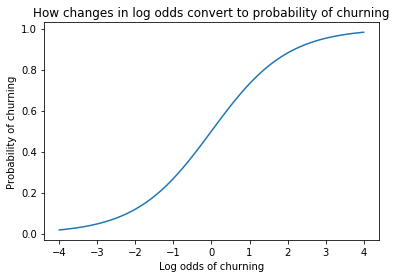

In [42]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of churning")
plt.ylabel("Probability of churning")
plt.title("How changes in log odds convert to probability of churning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

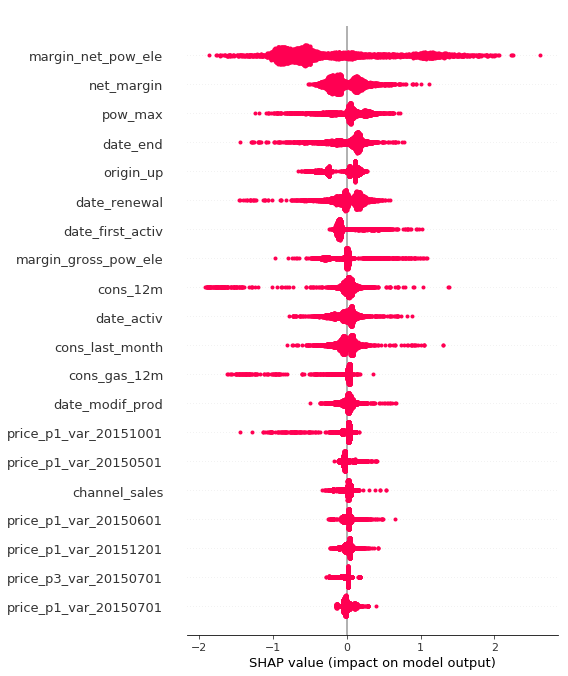

In [43]:
shap.summary_plot(shap_values, Xv.columns, max_display=20)

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:687: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


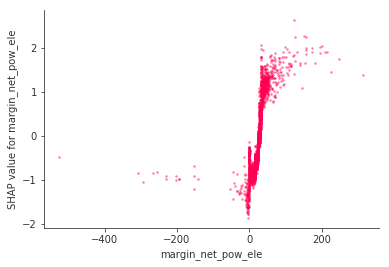

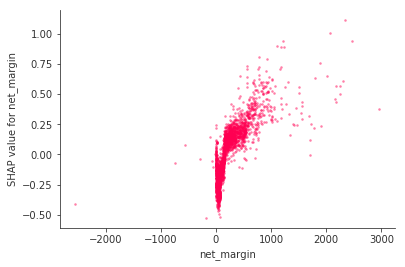

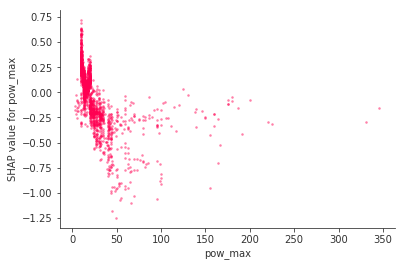

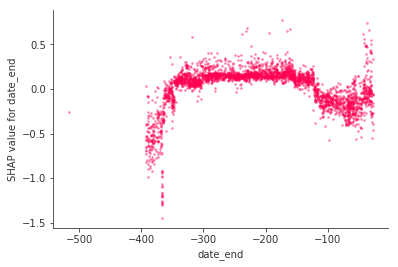

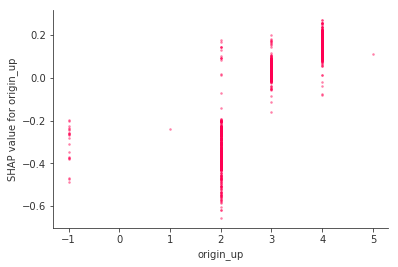

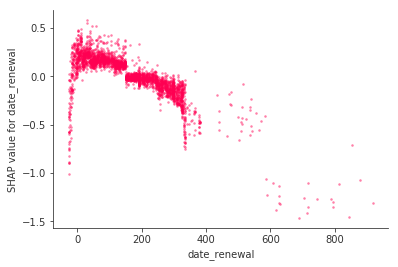

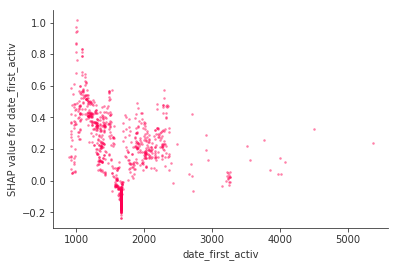

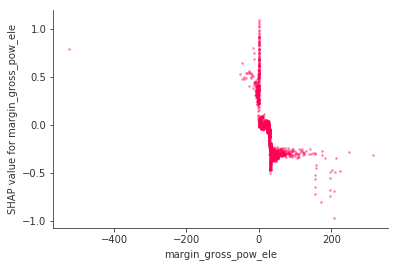

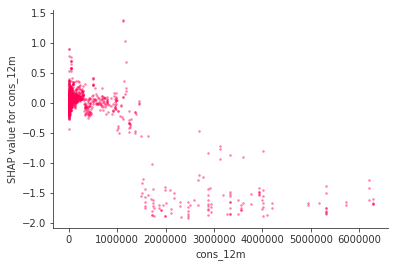

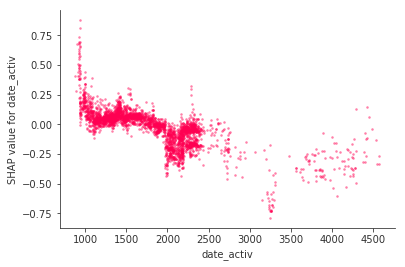

In [44]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[:,:len(features)]), 0))
for i in range(10):
    shap.plot(Xv.iloc[:,top_inds[i]], shap_values[:,top_inds[i]], Xv.columns[top_inds[i]], alpha=0.5)

In [45]:
top_inds

array([ 6,  8,  4, 15, 13, 18, 16,  9,  2, 14,  0,  1, 17, 40, 35, 11, 36,
       42, 85, 37,  5, 38, 55, 10, 65, 77, 31, 81, 62, 78, 41, 30, 21, 43,
       67, 33, 84, 87, 34, 39, 66, 79, 59, 12, 32, 56, 54, 57, 88, 80, 47,
        7, 82, 64, 90, 76, 63, 25, 71, 89, 61, 27, 60, 73, 22, 58,  3, 20,
       28, 83, 23, 24, 19, 26, 86, 52, 72, 74, 53, 70, 69, 68, 29, 44, 46,
       48, 49, 50, 51, 75, 45], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:642: UserWarning: shap.interaction_plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.interaction_plot is deprecated in favor of shap.dependence_plot")


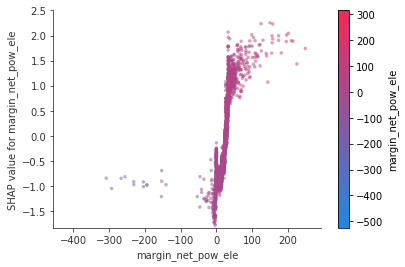

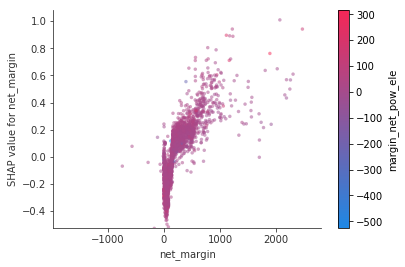

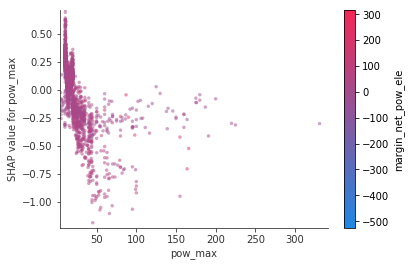

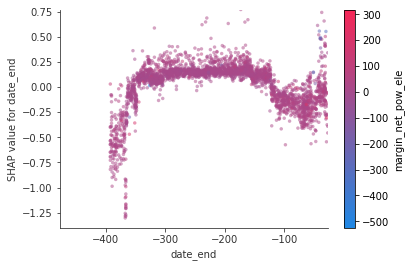

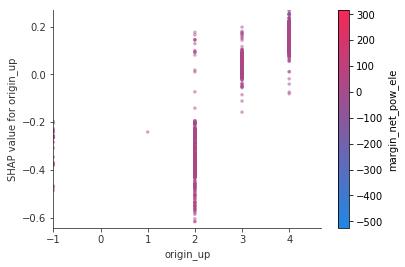

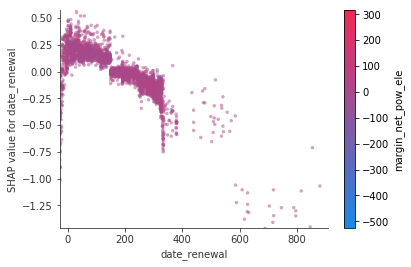

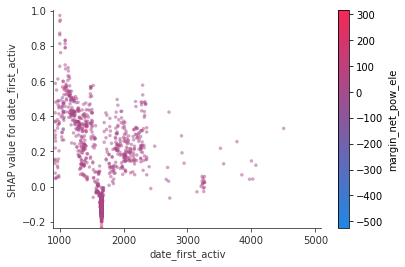

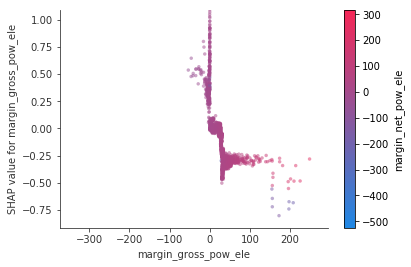

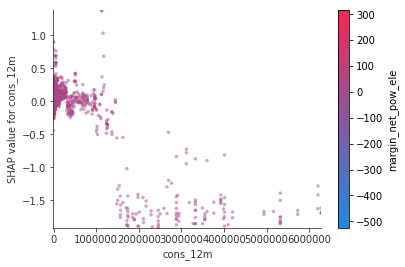

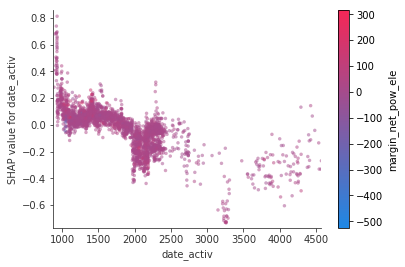

In [46]:
for i in range(10):
    plt.xlim(np.percentile(Xv.iloc[:,top_inds[i]], 0.01), np.percentile(Xv.iloc[:,top_inds[i]], 99.99))
    plt.ylim(np.percentile(shap_values[:,top_inds[i]], 0.01), np.percentile(shap_values[:,top_inds[i]], 99.99))
    shap.interaction_plot(top_inds[i], Xv, shap_values, alpha=.5, interaction_index=6)

### Train a model on just one feature to see marginal association

In [49]:
ind = np.where(Xv.columns == features[top_inds[0]])[0][0]
Xt_min = Xt.iloc[:,ind:ind+1]
Xv_min = Xv.iloc[:,ind:ind+1]
dt_min = xgb.DMatrix(Xt_min,label=yt.as_matrix())
dv_min = xgb.DMatrix(Xv_min,label=yv.as_matrix())
params = {
    "eta": 0.1,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model_min = xgb.train(params, dt_min, 100, [(dt_min, "train"),(dv_min, "valid")], verbose_eval=10)

[0]	train-logloss:0.324127	valid-logloss:0.309293
[10]	train-logloss:0.315311	valid-logloss:0.302996
[20]	train-logloss:0.312775	valid-logloss:0.302362
[30]	train-logloss:0.311043	valid-logloss:0.302314
[40]	train-logloss:0.309892	valid-logloss:0.302451
[50]	train-logloss:0.30865	valid-logloss:0.302769
[60]	train-logloss:0.30746	valid-logloss:0.302913
[70]	train-logloss:0.306524	valid-logloss:0.303122
[80]	train-logloss:0.305667	valid-logloss:0.303319
[90]	train-logloss:0.304672	valid-logloss:0.303326
[99]	train-logloss:0.304025	valid-logloss:0.303586


In [50]:
shap_values_min = model_min.predict(dv_min, pred_contribs=True)

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:687: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


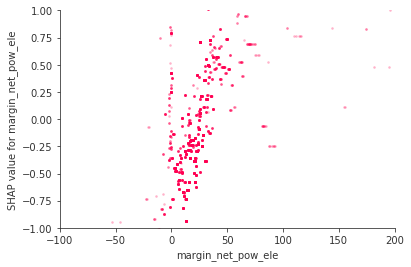

In [51]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv_min.iloc[:,0], shap_values_min[:,0], Xv_min.columns[0], alpha=0.3)

### Train a model with only two leaves per tree and hence no interaction terms between features

In [52]:
params = {
    "max_bin": 512,
    "eta": 0.1,
    "num_leaves": 2,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    "min_data": 100,
    "boost_from_average": True,
    "verbose": -1,
}

model_ind = xgb.train(params, dt, 200, [(dt, "train"),(dv, "valid")], verbose_eval=100)

[0]	train-logloss:0.318618	valid-logloss:0.305987
[100]	train-logloss:0.203992	valid-logloss:0.267044
[199]	train-logloss:0.157593	valid-logloss:0.267312


In [53]:
shap_values_ind = model_ind.predict(dv, pred_contribs=True)

In [54]:
np.argsort(-np.sum(np.abs(shap_values_ind[:,:len(features)]), 0))

array([ 6,  9,  4, 18, 13,  2, 15,  8, 16,  0, 14,  1, 17, 35, 41,  5, 11,
       36, 40, 55, 34, 42, 37, 10, 31, 38, 63, 77, 65, 33, 32, 79, 81, 60,
       61, 66, 39, 21, 85, 84, 89, 30, 59, 62, 82, 86, 58, 67,  7, 87, 56,
       88, 90, 64, 57, 29, 28, 12, 47, 83, 23, 26, 24, 80, 52, 25, 43,  3,
       78, 50, 73, 19, 48, 76, 75, 53, 72, 44, 71, 54, 20, 74, 69, 46, 51,
       70, 68, 49, 45, 27, 22], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:687: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


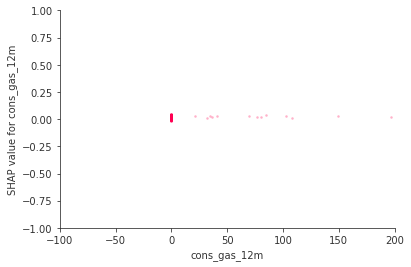

In [55]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,1], shap_values[:,1], Xv.columns[1], alpha=0.3)

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:687: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


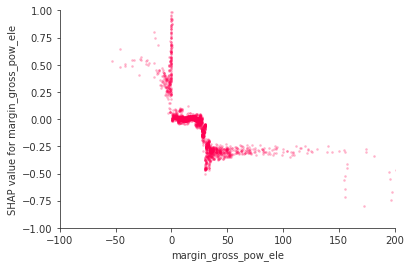

In [56]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,9], shap_values[:,9], Xv.columns[9], alpha=0.3)

C:\ProgramData\Anaconda3\lib\site-packages\shap\plots.py:687: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


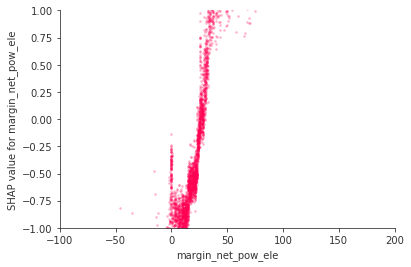

In [57]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,6], shap_values[:,6], Xv.columns[6], alpha=0.3)

# Submission model

In [58]:
params = {
    "eta": 0.01,
    "max_depth": 6,
    "objective": "binary:logistic",
    "silent": 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 1800, [(dt, "train"),(dv, "valid")], verbose_eval=100)

[0]	train-logloss:0.325402	valid-logloss:0.310303
[100]	train-logloss:0.283204	valid-logloss:0.286615
[200]	train-logloss:0.265094	valid-logloss:0.279271
[300]	train-logloss:0.253204	valid-logloss:0.275392
[400]	train-logloss:0.242242	valid-logloss:0.272541
[500]	train-logloss:0.23259	valid-logloss:0.270622
[600]	train-logloss:0.224117	valid-logloss:0.269089
[700]	train-logloss:0.215737	valid-logloss:0.267962
[800]	train-logloss:0.207511	valid-logloss:0.267419
[900]	train-logloss:0.200038	valid-logloss:0.266736
[1000]	train-logloss:0.193209	valid-logloss:0.266071
[1100]	train-logloss:0.186407	valid-logloss:0.265461
[1200]	train-logloss:0.179864	valid-logloss:0.264961
[1300]	train-logloss:0.17363	valid-logloss:0.264722
[1400]	train-logloss:0.168359	valid-logloss:0.264304
[1500]	train-logloss:0.16294	valid-logloss:0.264093
[1600]	train-logloss:0.157715	valid-logloss:0.264146
[1700]	train-logloss:0.152887	valid-logloss:0.264041
[1799]	train-logloss:0.148096	valid-logloss:0.263716


In [59]:
model.predict(xgb.DMatrix(X.as_matrix()))

array([0.0243265 , 0.6908387 , 0.05708662, ..., 0.3007975 , 0.04974604,
       0.06903097], dtype=float32)

### Submission is made in a way to reach 50% precision

In [60]:
score_topK(yv, model.predict(dv))

Precision @
TOP K 50 
-- 0.84 #Churners: 50 #TT: 42 #FT: 8
TOP K 100 
-- 0.69 #Churners: 100 #TT: 69 #FT: 31
TOP K 150 
-- 0.57 #Churners: 150 #TT: 85 #FT: 65
TOP K 175 
-- 0.50 #Churners: 175 #TT: 88 #FT: 87


0.2519563

In [61]:
Xs = df.loc[df.churn.isnull(), features]
ds = xgb.DMatrix(Xs.as_matrix())

In [62]:
Xs['Churn_probability'] = model.predict(ds)
Xs.loc[Xs.Churn_probability>0.2481351, 'Churn_prediction'] = 1

In [63]:
pd.read_csv(path+'ml_case_test_output_template.csv', 
            usecols=['id'], index_col=0).join(Xs[['Churn_prediction','Churn_probability']]).fillna(0).to_csv(
'ml_case_test_output.csv')

In [64]:
! head ml_case_test_output.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


### Churn_probability threshold were we can make 20% discount

In [65]:
res = Xv.copy()
res['Churn_probability'] = model.predict(dv)
res['Churn_true'] = yv
res = res[['Churn_probability','Churn_true']].sort_values('Churn_probability', ascending=False)
res['ranking0'] = range(1,res.shape[0]+1)
res = res.join(df.forecast_bill_12m).dropna()
res['real_bill'] = res.forecast_bill_12m*(1-res.Churn_true)
res['new_bill'] = res.forecast_bill_12m*.8
res['gain'] = res.new_bill - res.real_bill
res['cum_gain'] = res['gain'].cumsum()
res['ranking'] = range(1,res.shape[0]+1)
print res.shape, Xv.shape
res.loc[res.ranking<=404].tail(20)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(res.shape, Xv.shape)? (<ipython-input-65-ea59a3a3b55d>, line 12)

# Extra

In [ ]:
params = {'nthread':[1],
          'objective':['binary:logistic'],
          'learning_rate': [0.01],
          'max_depth': [5,6],
          'silent': [0],
          'subsample': [0.6,0.8],
          'colsample_bytree': [0.6,0.8],
          'n_estimators': [1500],
          #'missing':[-999],
          'seed': [1227]
}
from sklearn.cross_validation import StratifiedKFold
clf = GridSearchCV(xgb.XGBClassifier(), params, n_jobs=4, 
                   cv=StratifiedKFold(yt, n_folds=2, shuffle=True), 
                   scoring='roc_auc',
                   verbose=0, refit=True)
clf.fit(Xt, yt)

In [ ]:
clf.best_estimator_

In [ ]:
df=get_df(scale=True, fillna=True)

In [ ]:
df['cons_12m'].max()